In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import configparser
import seaborn as sns
import shap
import sqlite3


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [39]:
config = configparser.ConfigParser()
config.read('config.config')
fichier = config['Settings']['fichier']
ligne_debut = int(config['Settings']['ligne_debut'])
seed = int(config['Settings']['SEED'])

### Définir la seed

In [40]:
np.random.seed(seed)

### Charger le fichier

In [41]:
data = pd.read_excel(fichier, skiprows=ligne_debut)
data = data.sample(n=1000, random_state=seed)

### Supprimer les colonnes de quantité et CA

In [42]:
data = data.drop(['Qté facturée (Base Unit)','CA Net'], axis = 1)

### Changer le type de données dans certaines colonnes

In [43]:
data['Poids Net'] = pd.to_numeric(data['Poids Net'], errors='coerce')
data['Donneur d\'ordre'] = data['Donneur d\'ordre'].astype(str)

### Diviser la date en année et mois

In [44]:
data[['Mois de facturation', 'Année de facturation']] = data['Mois/Année de facturation'].astype(str).str.split('.', expand=True)

data = data.drop(['Mois/Année de facturation'], axis = 1)

### Retirer les poids négatifs ou nuls

In [45]:
data = data.loc[data['Poids Net'] >0]
# Vérifier que le minimum de la colonne est supérieur ou égal à zéro
assert (data[['Poids Net']] > 0).all().all(), "Il y a des valeurs négatives dans les données d'origine"

### Retirer les articles finissant par -999 ou -998

In [46]:
data = data[~data['Article'].str.endswith(('-999', '-998'))]
# Vérifier qu'il ne reste pas d'articles finissant par -999 ou -998
assert (~data['Article'].str.endswith(('-999', '-998'))).all(), "Il reste des articles finissant par -999 ou -998"

### Retirer les données pour un donneur d'ordre qui commence par EPREST

In [47]:
data = data[~data['Article'].str.startswith(('EPREST'))]
# Vérifier qu'il ne reste pas d'articles commençant par EPREST
assert (~data['Article'].str.startswith(('EPREST'))).all(), "Il reste des articles commençant par EPREST"

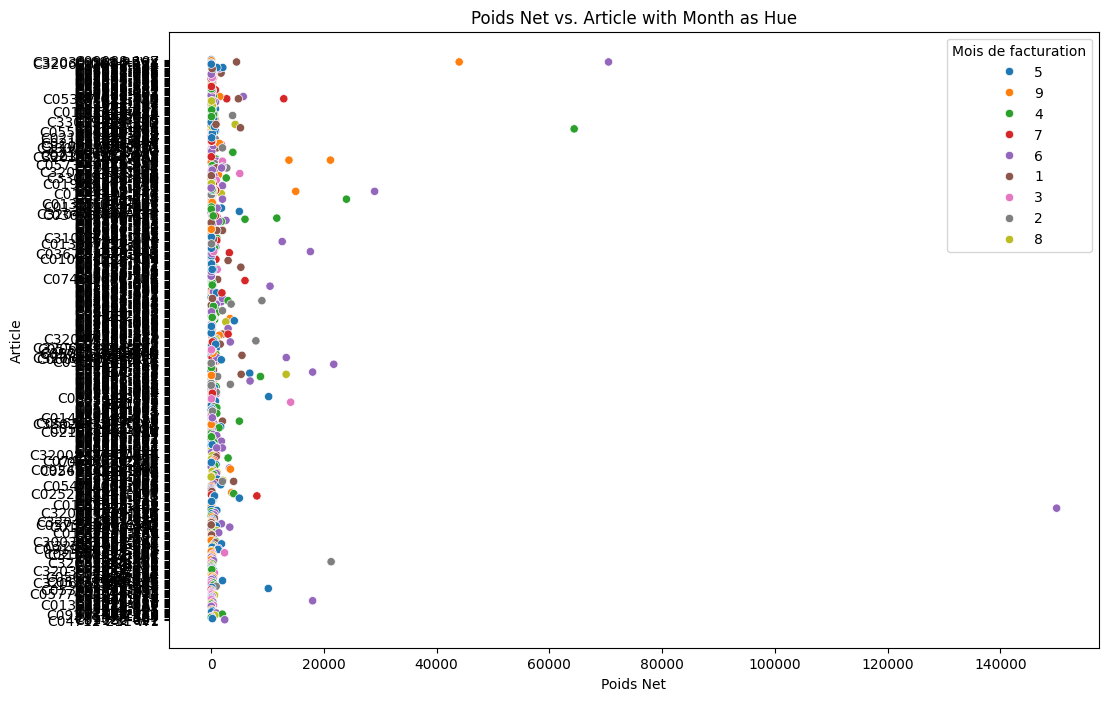

In [48]:
# Creating a scatter plot with a unique color for each article and using the month for hue
plt.figure(figsize=(12, 8))
sns.scatterplot(data=data, x='Poids Net', y='Article', hue='Mois de facturation', palette='tab10', legend='full')

# Adding titles and labels
plt.title('Poids Net vs. Article with Month as Hue')
plt.xlabel('Poids Net')
plt.ylabel('Article')

# Display the plot
plt.show()

### Transformer les données

In [49]:
data = pd.get_dummies(data, columns=['Donneur d\'ordre','Article','Mois de facturation','Année de facturation'])

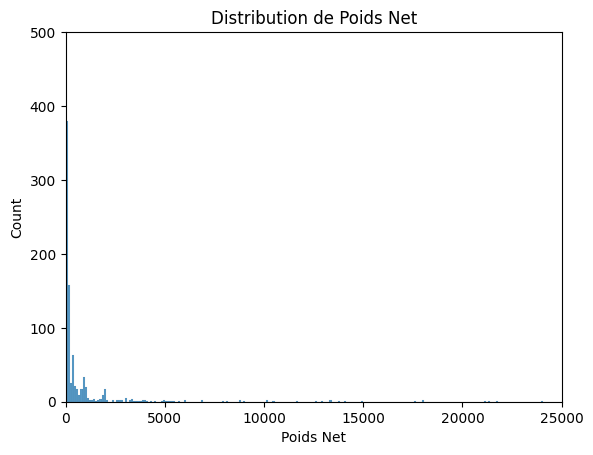

In [50]:
sns.histplot(data['Poids Net'])
plt.title(f'Distribution de Poids Net')
plt.xlim(0,25000)
plt.ylim(0,500)
plt.show()

### Définir X et y

In [51]:
X = data.drop(['Poids Net'], axis = 1)
y = data[['Poids Net']]

print(X)
print(y)

       Donneur d'ordre_10076195  Donneur d'ordre_10076236  \
2293                      False                     False   
26309                     False                     False   
26216                     False                     False   
5185                      False                     False   
24279                     False                     False   
...                         ...                       ...   
20674                     False                     False   
40463                     False                     False   
17758                     False                     False   
23383                     False                     False   
38608                     False                     False   

       Donneur d'ordre_10076434  Donneur d'ordre_10076707  \
2293                      False                     False   
26309                     False                     False   
26216                     False                     False   
5185                   

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
# print(X_test)
print(X_train)
print(y_train)
model = LinearRegression()
model.fit(X_train, y_train)

       Donneur d'ordre_10076195  Donneur d'ordre_10076236  \
35348                     False                     False   
12301                     False                     False   
440                       False                     False   
25017                     False                      True   
29800                     False                     False   
...                         ...                       ...   
35435                     False                     False   
33367                     False                     False   
17178                     False                     False   
29156                     False                     False   
10995                     False                     False   

       Donneur d'ordre_10076434  Donneur d'ordre_10076707  \
35348                     False                     False   
12301                     False                     False   
440                       False                     False   
25017                  

LinearRegression()

In [53]:
print(X_test)
y_pred = model.predict(X_test)
print(y_pred)

       Donneur d'ordre_10076195  Donneur d'ordre_10076236  \
11035                     False                     False   
6611                      False                     False   
18979                     False                     False   
23828                     False                     False   
34569                     False                     False   
...                         ...                       ...   
6990                      False                     False   
17290                     False                     False   
17990                     False                     False   
26815                     False                     False   
4211                      False                     False   

       Donneur d'ordre_10076434  Donneur d'ordre_10076707  \
11035                     False                     False   
6611                      False                     False   
18979                     False                     False   
23828                  

## Analyse Shap

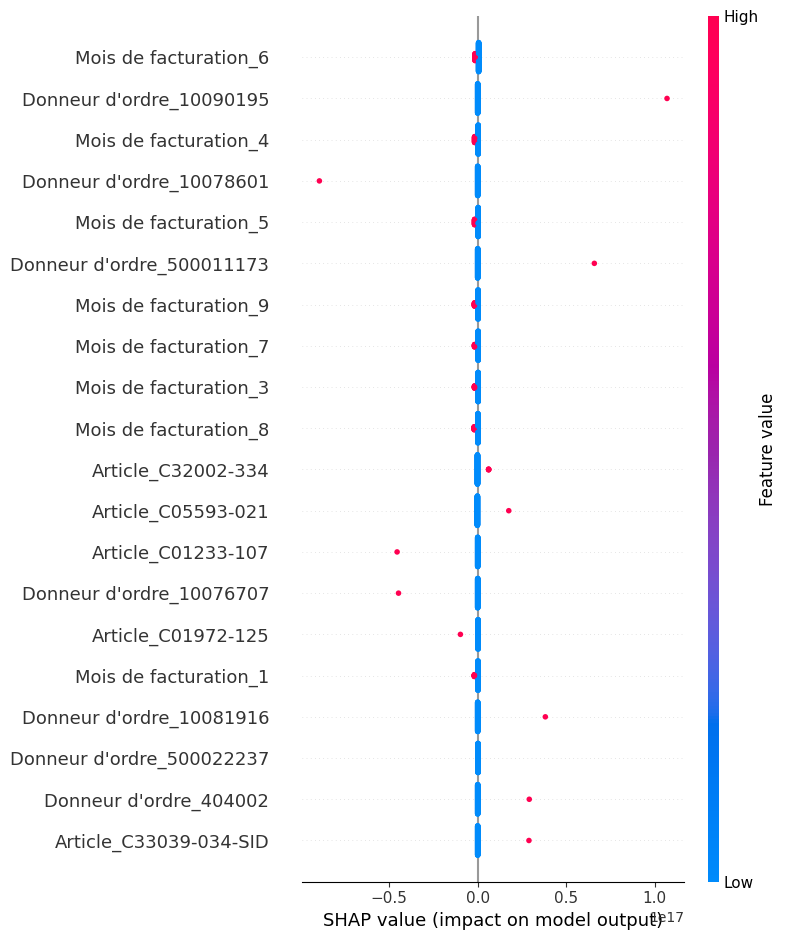

In [54]:
# Initialiser l'analyse SHAP
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Visualiser les résultats
shap.summary_plot(shap_values, X_test)

In [55]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(mse)
print(mae)
print(r2)

1.9953837389470583e+32
5110239574118630.0
-2.4587133993473363e+25


## Graphique des prédictions VS valeurs réelles

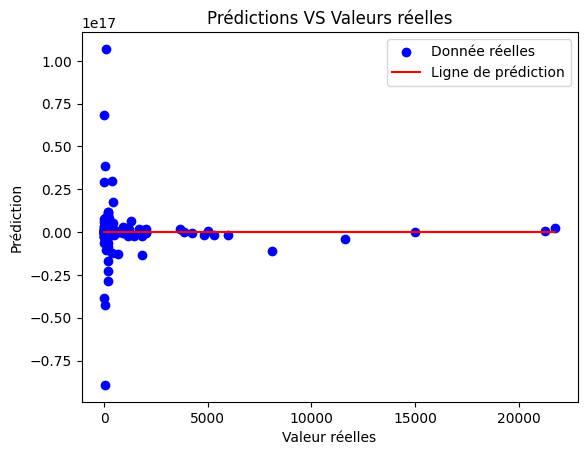

In [56]:
plt.scatter(y_test, y_pred, color='blue', label='Donnée réelles')
plt.plot(y_test, y_test, color='red', label='Ligne de prédiction')
plt.xlabel('Valeur réelles')
plt.ylabel('Prédiction')
plt.title('Prédictions VS Valeurs réelles')
plt.legend()
plt.show()

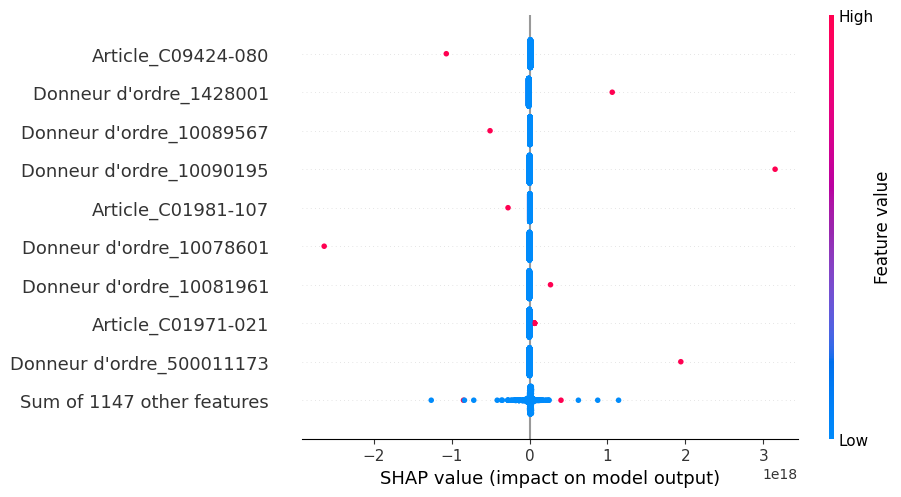

In [57]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

explainer = shap.LinearExplainer(model, X_scaled)
x_explained = explainer(X_scaled)

for key, value in enumerate(X.columns):
    x_explained.feature_names[key] = value

x_explained.data = X.values

shap.plots.beeswarm(x_explained)